In [1]:
import numpy as np
import pandas as pd
import yaml

from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load the data

In [2]:
# Load the MSI data
peaks = pd.read_feather("workspace/data/mse_conc_peaks_complete.feather")
pixels = pd.read_feather("workspace/data/mse_conc_pixels_complete.feather")

# Define the densities and a threshold for each pixel density

In [3]:
# Determine the densities of the selected pixels
densities = [col for col in pixels.columns if 'Density' in col][2:]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

# Remove the Trypsin peaks

In [4]:
# Load the trypsin peaks from a file
with open("workspace/trypsin_peaks.yml", "r") as f:
    trypsin_masses = yaml.safe_load(f)

# Extract the trypsin peaks
trypsin_peaks = [peak for peak in peaks.columns if np.min(np.abs(float(peak) - np.array(trypsin_masses))) < 0.2]

print(f"Found {len(trypsin_peaks)} trypsin peaks")
for peak in trypsin_peaks:
    print(f"peak: {float(peak)}, mass: {trypsin_masses[np.argmin(np.abs(float(peak) - np.array(trypsin_masses)))]:.2f} ,diff: {np.min(np.abs(float(peak) - np.array(trypsin_masses))):.2f}")

Found 12 trypsin peaks
peak: 515.3292, mass: 515.33 ,diff: 0.00
peak: 842.476, mass: 842.51 ,diff: 0.03
peak: 906.3916, mass: 906.50 ,diff: 0.11
peak: 1006.4606, mass: 1006.49 ,diff: 0.03
peak: 1045.5339, mass: 1045.56 ,diff: 0.03
peak: 1469.6891, mass: 1469.73 ,diff: 0.04
peak: 1736.8208, mass: 1736.84 ,diff: 0.02
peak: 1768.823, mass: 1768.80 ,diff: 0.02
peak: 2158.0994, mass: 2158.03 ,diff: 0.07
peak: 2211.0896, mass: 2211.10 ,diff: 0.01
peak: 2283.1072, mass: 2283.18 ,diff: 0.07
peak: 3013.4917, mass: 3013.32 ,diff: 0.17


In [5]:
# Check if the auc_scores file exists:
try:
    auc_scores = pd.read_csv("workspace/data/auc_scores.csv")
except FileNotFoundError:
    # Calculate AUC for each mass in the peaks
    auc_scores = pd.DataFrame(data={"Mass":peaks.columns,
                                    "All": [roc_auc_score(pixels["Density_CD8"] > threshold['Density_CD8'], peaks[mass]) for mass in peaks.columns]})

    # Calculate AUC for each mass in the peaks for each slide 
    for lame in lames:
        pixels_lame = pixels[pixels['run'] == lame]
        peaks_lame = peaks[pixels['run'] == lame]
        auc_scores[lame] = [roc_auc_score(pixels_lame["Density_CD8"] > threshold['Density_CD8'], peaks_lame[mass]) for mass in peaks.columns]
    # Save the AUC scores
    auc_scores.to_csv("workspace/data/auc_scores.csv", index=False)

auc_scores

,Mass,All,12AG01290_19,12AG01290_26,13AG00043_26,13AG00043-36,13AG01113-14,13AG01113-15,13AG03225-06,13AG03225-20,13AG04268-11,14AG03250-31,14AG03250-37,14AG03250-38
0,500.2859,0.534063,0.315576,0.350363,0.580471,0.269114,0.447859,0.462623,0.682328,0.537753,0.648069,0.790656,0.572952,0.627361
1,501.2941,0.550462,0.314609,0.365759,0.589137,0.243504,0.493770,0.491781,0.705923,0.571826,0.652125,0.816176,0.617523,0.632119
2,502.2811,0.529920,0.303511,0.353608,0.540209,0.252197,0.470441,0.478119,0.680605,0.552795,0.660708,0.798800,0.657195,0.617188
3,503.2805,0.530732,0.306350,0.344833,0.557930,0.254796,0.481000,0.483377,0.697539,0.545604,0.648994,0.796522,0.661099,0.625158
4,504.2638,0.536909,0.307838,0.345842,0.561899,0.253604,0.447566,0.471824,0.706190,0.551930,0.648267,0.798077,0.615661,0.617303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,3598.7654,0.505395,0.537581,0.504202,0.510134,0.600367,0.478429,0.494647,0.421587,0.481641,0.468995,0.418678,0.453479,0.482991
3590,3599.1399,0.503257,0.521882,0.494074,0.502725,0.593908,0.488927,0.499784,0.435148,0.484537,0.473295,0.433593,0.458091,0.496880
3591,3599.3677,0.504587,0.522005,0.494883,0.504264,0.600133,0.487267,0.506220,0.435203,0.485901,0.479607,0.439526,0.462748,0.490892
3592,3599.6829,0.510027,0.544102,0.506694,0.506392,0.593159,0.479917,0.500822,0.422617,0.484045,0.468955,0.417681,0.461466,0.482860


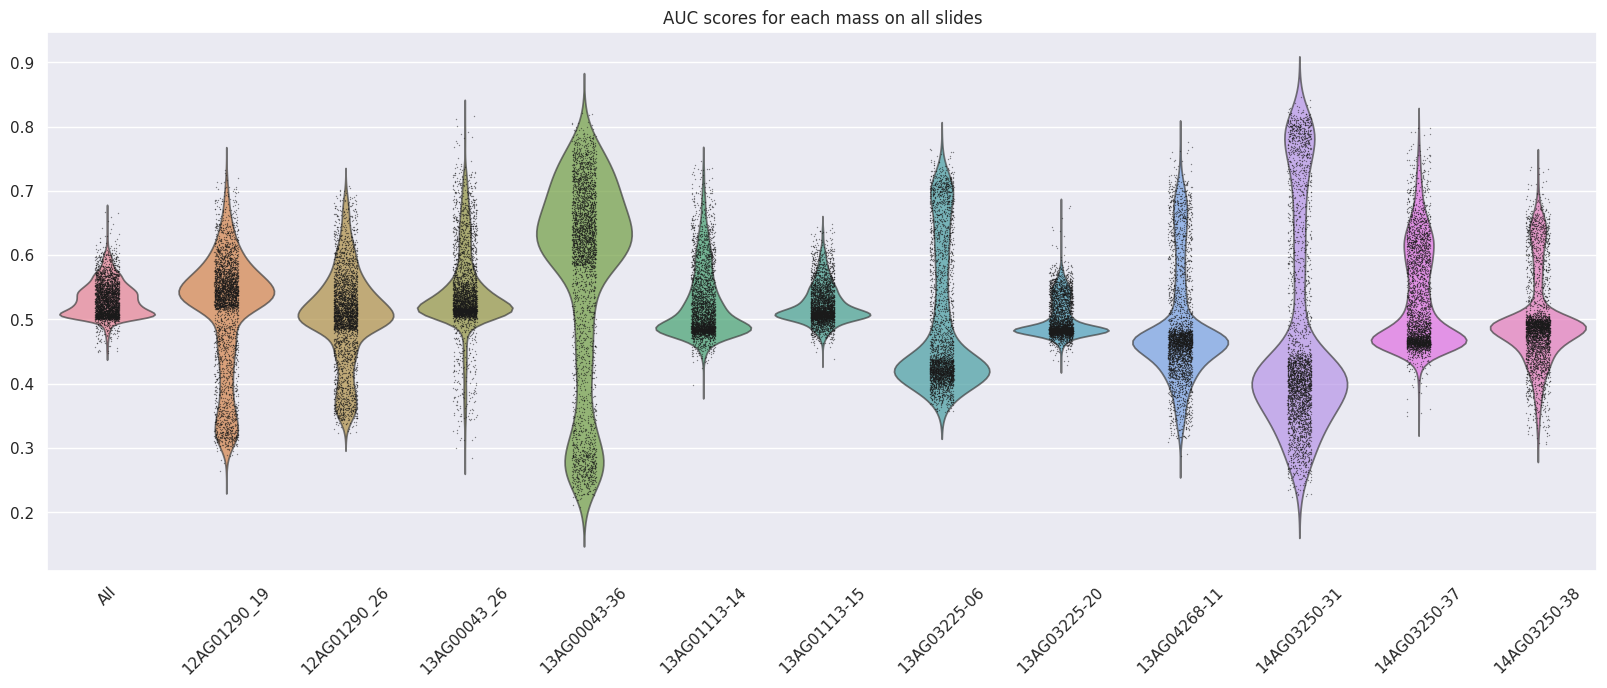

In [6]:
# Plot the AUC scores for each mass and slide as a violin plot
plt.figure(figsize=(20, 7))
sns.violinplot(data=auc_scores.drop(columns=["Mass"]), alpha=0.7, inner=None)
sns.stripplot(data=auc_scores.drop(columns=["Mass"]), alpha=0.5, color="k", size=1)
plt.xticks(rotation=45)
plt.title("AUC scores for each mass on all slides")
plt.show()

In [7]:
# Noramlize the peaks by root mean square
peaks_norm = peaks.copy()
for lame in lames:
    normalization = np.sqrt(np.mean(peaks_norm[pixels['run'] == lame]**2, axis=1))
    peaks_norm[pixels['run'] == lame] = peaks_norm[pixels['run'] == lame].div(normalization, axis=0)

In [8]:
# Check if the auc_scores_norm file exists:
try:
    auc_scores_norm = pd.read_csv("workspace/data/auc_scores_norm.csv")
except FileNotFoundError:
    # Calculate AUC for each mass in the peaks
    auc_scores_norm = pd.DataFrame(data={"Mass":peaks.columns,
                                    "All": [roc_auc_score(pixels["Density_CD8"] > threshold['Density_CD8'], peaks_norm[mass]) for mass in peaks_norm.columns]})

    # Calculate AUC for each mass in the peaks for each slide 
    for lame in lames:
        pixels_lame = pixels[pixels['run'] == lame]
        peaks_lame = peaks_norm[pixels['run'] == lame]
        auc_scores_norm[lame] = [roc_auc_score(pixels_lame["Density_CD8"] > threshold['Density_CD8'], peaks_lame[mass]) for mass in peaks_norm.columns]
    # Save the AUC scores
    auc_scores_norm.to_csv("workspace/data/auc_scores_norm.csv", index=False)

auc_scores_norm

,Mass,All,12AG01290_19,12AG01290_26,13AG00043_26,13AG00043-36,13AG01113-14,13AG01113-15,13AG03225-06,13AG03225-20,13AG04268-11,14AG03250-31,14AG03250-37,14AG03250-38
0,500.2859,0.487957,0.324972,0.321767,0.591069,0.314624,0.379987,0.421586,0.631581,0.502245,0.652479,0.761947,0.506651,0.698277
1,501.2941,0.506482,0.313650,0.335992,0.592726,0.261522,0.405931,0.447623,0.667704,0.547426,0.657340,0.814084,0.569294,0.688473
2,502.2811,0.486571,0.301993,0.322984,0.544753,0.280026,0.393729,0.436678,0.642961,0.523716,0.664236,0.794392,0.617281,0.671475
3,503.2805,0.492246,0.295546,0.312867,0.561777,0.276708,0.393655,0.439141,0.676668,0.522291,0.656129,0.792490,0.634355,0.675534
4,504.2638,0.497199,0.298919,0.314070,0.566426,0.280145,0.371423,0.428882,0.677257,0.525238,0.652900,0.790735,0.565774,0.669169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3589,3598.7654,0.475045,0.551786,0.490399,0.535700,0.632091,0.445921,0.476769,0.401474,0.462672,0.480218,0.382305,0.420013,0.510834
3590,3599.1399,0.472983,0.538813,0.482899,0.529766,0.624804,0.453840,0.482016,0.410411,0.464704,0.483244,0.393628,0.426935,0.519335
3591,3599.3677,0.474385,0.538913,0.483769,0.530945,0.629692,0.453775,0.486454,0.410345,0.466224,0.489482,0.398386,0.430035,0.512532
3592,3599.6829,0.480339,0.557588,0.493404,0.532656,0.624846,0.447766,0.481881,0.402728,0.466115,0.478832,0.380417,0.428696,0.502495


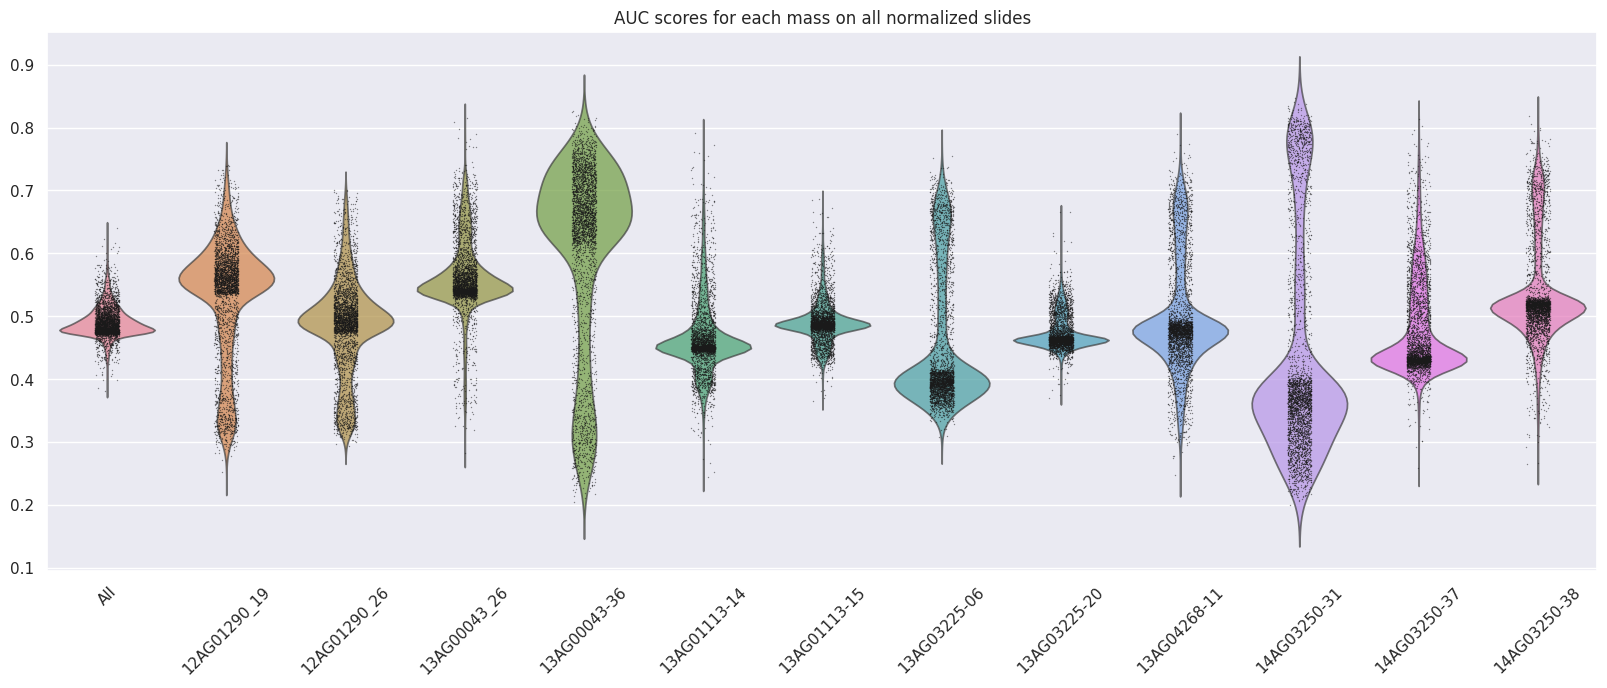

In [9]:
# Plot the AUC scores for each mass and slide as a violin plot
plt.figure(figsize=(20, 7))
sns.violinplot(data=auc_scores_norm.drop(columns=["Mass"]), alpha=0.7, inner=None)
sns.stripplot(data=auc_scores_norm.drop(columns=["Mass"]), alpha=0.5, color="k", size=1)
plt.xticks(rotation=45)
plt.title("AUC scores for each mass on all normalized slides")
plt.show()

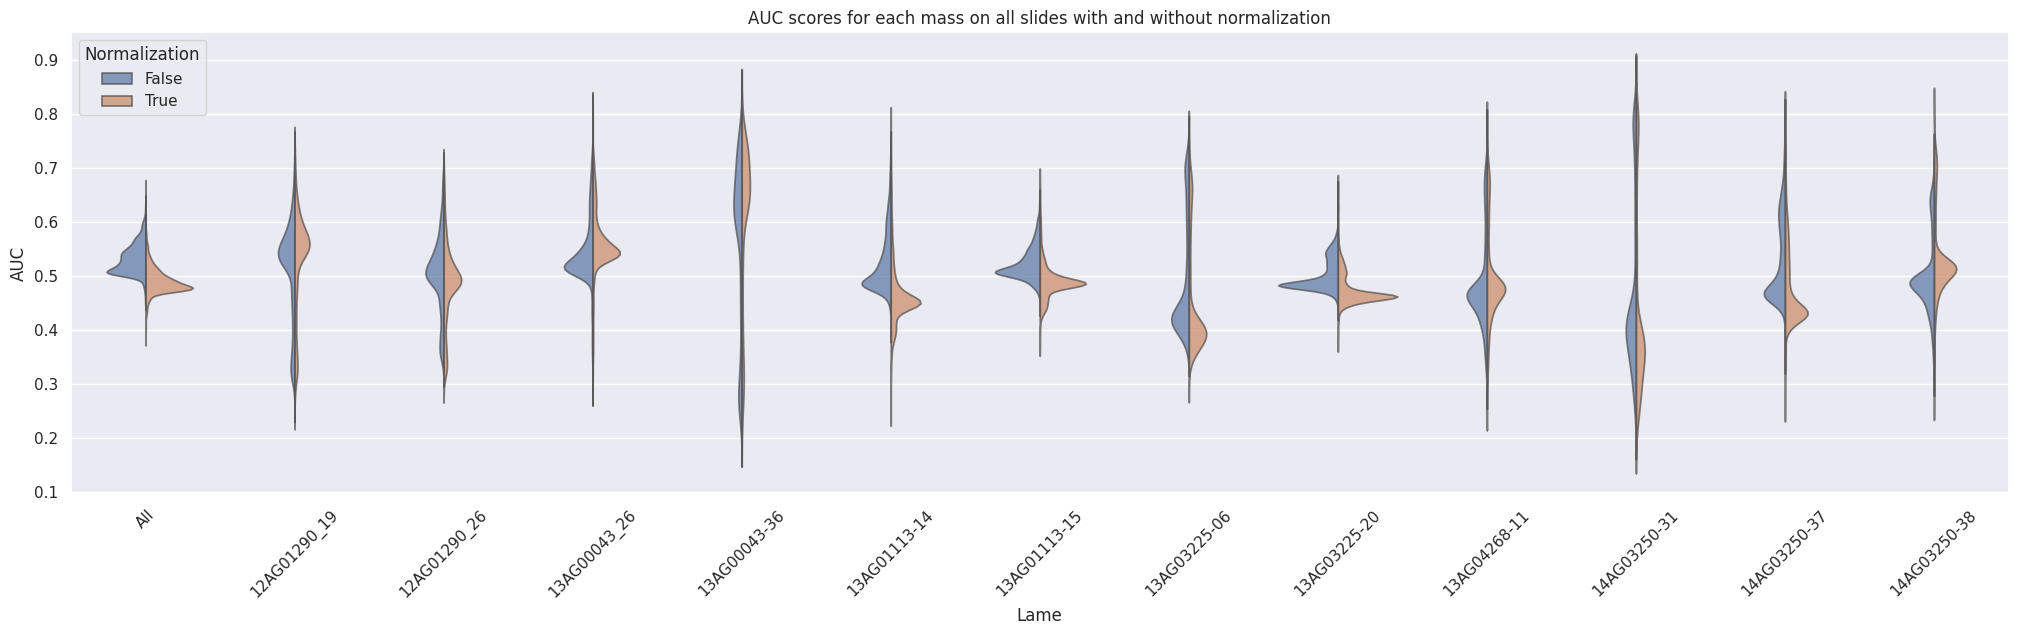

In [10]:
# Melt the auc_scores and auc_scores_norm with normalization true or false
auc_scores["Normalization"] = False
auc_scores_norm["Normalization"] = True
auc_scores_melt = pd.concat([auc_scores, auc_scores_norm], ignore_index=True)
auc_scores_melt = auc_scores_melt.melt(id_vars=["Mass", "Normalization"], var_name="Lame", value_name="AUC")

# Plot the AUC scores for each mass and slide as a violin plot
plt.figure(figsize=(25, 6))
sns.violinplot(data=auc_scores_melt.drop(columns=["Mass"]), x="Lame", y="AUC", hue="Normalization", alpha=0.7, inner=None, split=True)
plt.xticks(rotation=45)
plt.title("AUC scores for each mass on all slides with and without normalization")
plt.show()

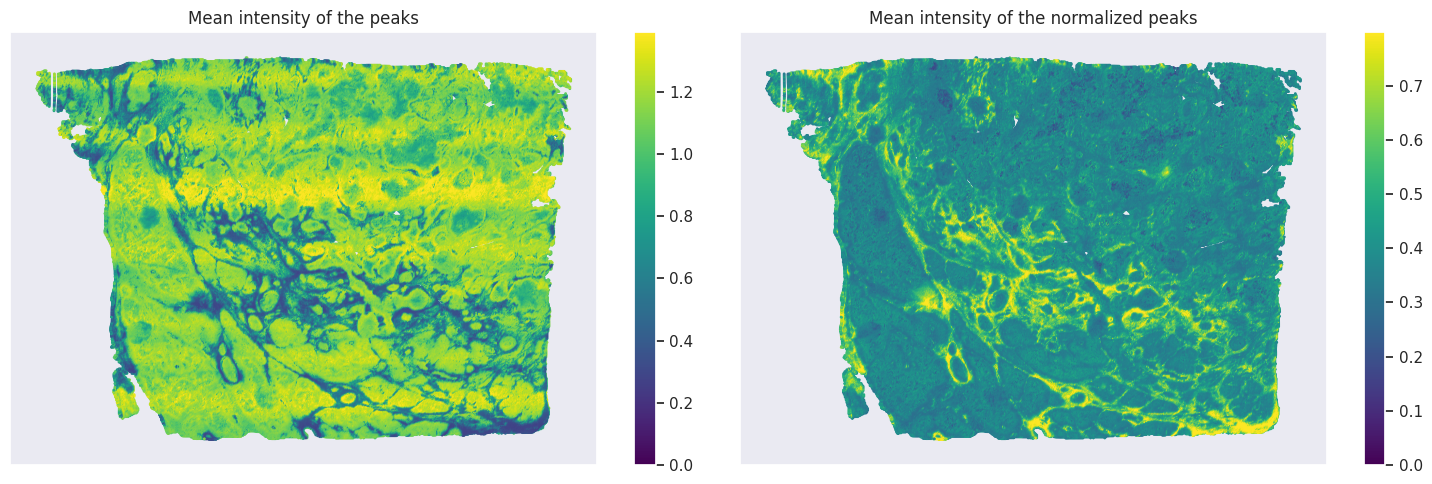

In [13]:
image = peaks[pixels['run'] == lames[0]].mean(axis=1)
image_normalized = peaks_norm[pixels['run'] == lames[0]].mean(axis=1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), tight_layout=True)

# Scatter the mean of the peaks
axs[0].scatter(x=pixels[pixels['run'] == lames[0]]['x_warped'], y=pixels[pixels['run'] == lames[0]]['y_warped'], c=image, cmap='viridis', s=1, vmin=0, vmax=image.quantile(0.99))
axs[0].set_title("Mean intensity of the peaks")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].axis('equal')
axs[0].invert_yaxis()
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x=pixels[pixels['run'] == lames[0]]['x_warped'], y=pixels[pixels['run'] == lames[0]]['y_warped'], c=image_normalized, cmap='viridis', s=1, vmin=0, vmax=image_normalized.quantile(0.99))
axs[1].set_title("Mean intensity of the normalized peaks")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].axis('equal')
axs[1].invert_yaxis()
fig.colorbar(axs[1].collections[0], ax=axs[1])

plt.show()

In [ ]:
normalization_median = peaks.median(axis=1)
normalization_mean = peaks.mean(axis=1)
normalization_max = peaks.max(axis=1)
normalization_sum = peaks.sum(axis=1)
normalization_quantile = peaks.quantile(0.95, axis=1)
normalization_rms = np.sqrt(np.mean(peaks**2, axis=1))